# Loading required libraries

In [5]:
 pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.9 MB/s 


In [6]:
import numpy as np                                # importing numpy numerical calculation
import pandas as pd                                 # importing pandas dataframe manipulation
import warnings                                     # removing the warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import category_encoders
from category_encoders import BinaryEncoder
from google.colab import files

# Uploading Dataset

In [8]:
uploaded = files.upload()

Saving LoanExport.csv to LoanExport.csv


# Reading the CSV data file using pandas

In [9]:
df = pd.read_csv('LoanExport.csv')

In [10]:
source_path = '/content/LoanExport.csv'
for i,chunk in enumerate(pd.read_csv(source_path, chunksize=200000)):
    chunk.to_csv('/content/LoanExportpart{}.csv'.format(i), index=False)

#reading a part of a file
df0 = pd.read_csv('/content/LoanExportpart0.csv')

# Defining Required Functions

In [11]:
def check_outliers0(x):
  global df0
  fig, axes = plt.subplots(1,2,figsize=(12,6))
  sns.distplot(df0[x],color='g',ax=axes[0])
  sns.boxplot(y=df0[x],color='g',ax=axes[1])
  axes[0].set_title('Distribution of ' + x)
  axes[1].set_title('Box plot of '+ x)
  plt.tight_layout()
  plt.show()
  print(df0.shape)

In [12]:
def remove_outliers0(x):
  global df0
  Q1= df0[x].quantile(0.25)
  Q3 = df0[x].quantile(0.75)
  IQR = Q3 - Q1
  upper_limit = Q3 + 1.5 * IQR
  lower_limit = Q1 - 1.5 * IQR
  df0=df0[(df0[x] > lower_limit) & (df0[x] < upper_limit)]
  fig, axes = plt.subplots(1,2,figsize=(12,6))
  sns.distplot(df0[x],color='g',ax=axes[0])
  sns.boxplot(y=df0[x],color='g',ax=axes[1])
  axes[0].set_title('Distribution of '+ x + ' without outliers')
  axes[1].set_title('Box plot of '+ x)
  plt.tight_layout()
  plt.show()
  print(df0.shape)

In [13]:
df0['CreditScore'].replace(to_replace = 0, value = 850, inplace=True)

In [14]:
df0['Units'].replace(to_replace = 0, value = 1, inplace=True)

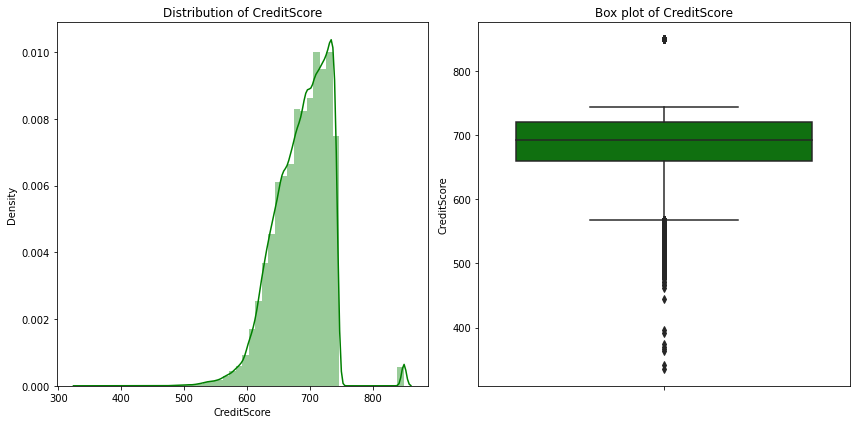

(200000, 28)


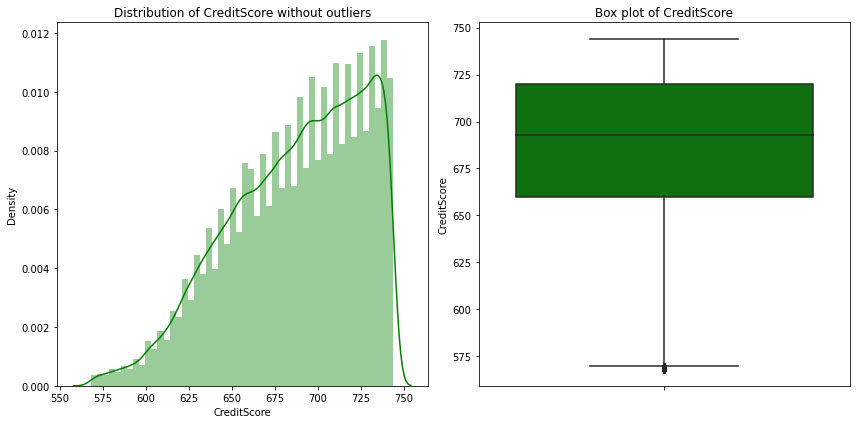

(197214, 28)




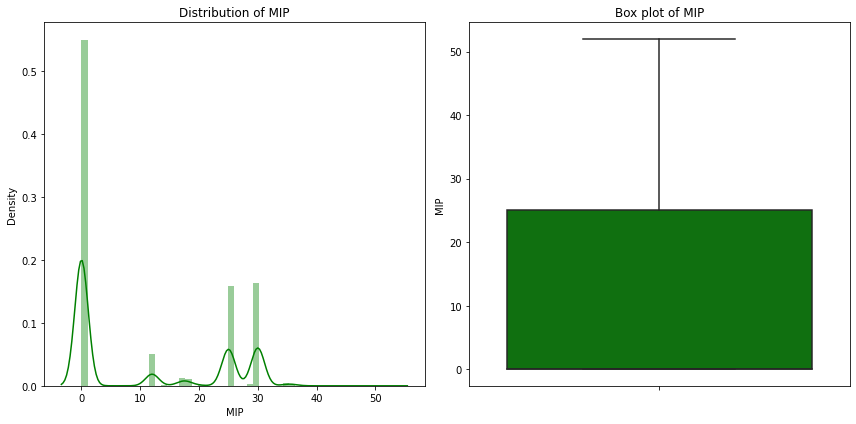

(197214, 28)




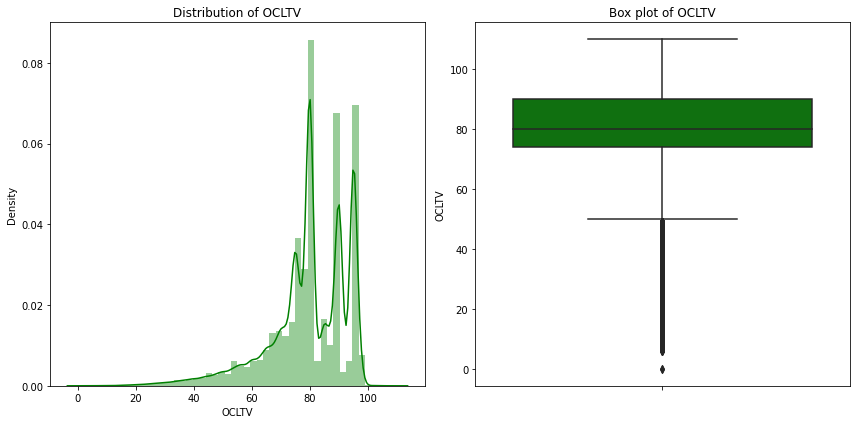

(197214, 28)


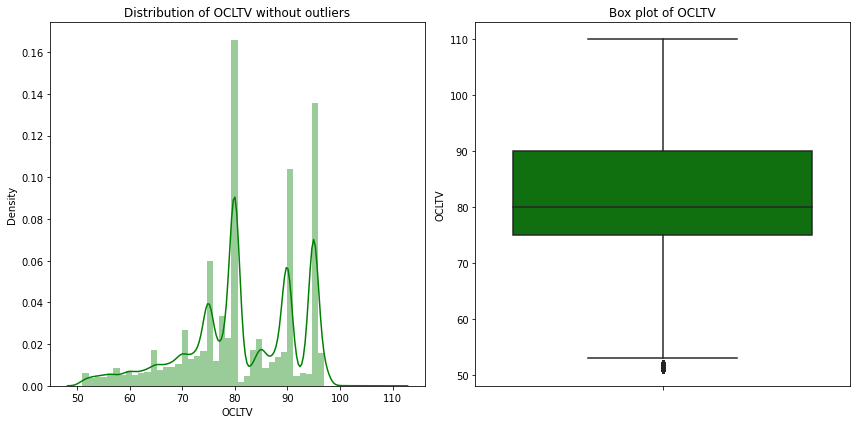

(188128, 28)




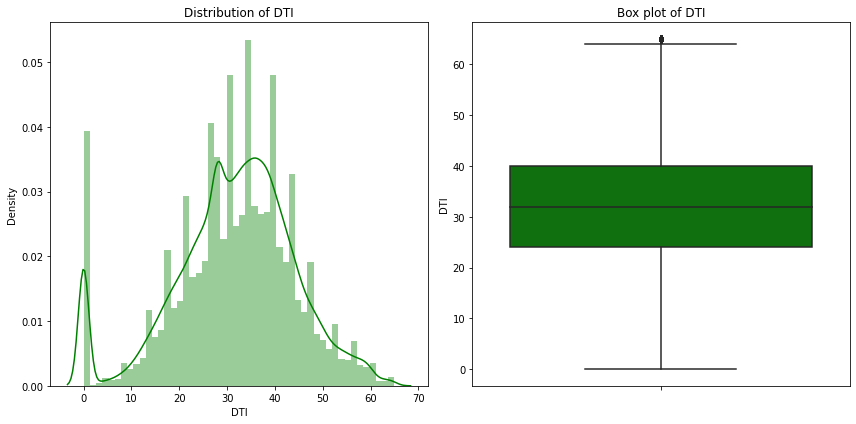

(188128, 28)


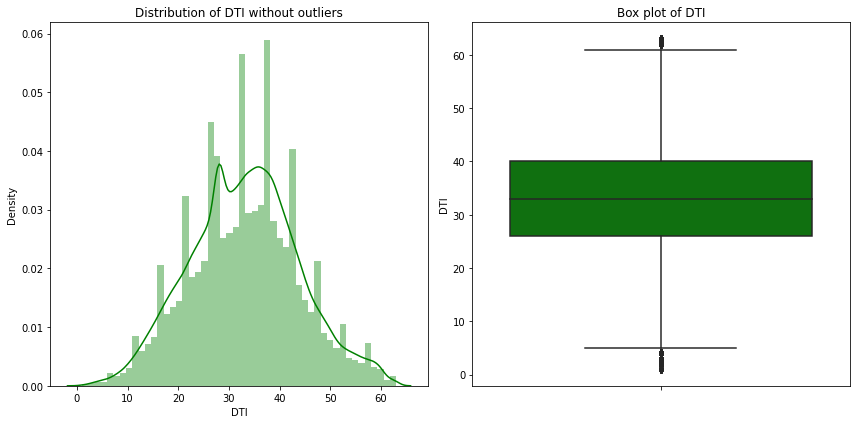

(178196, 28)




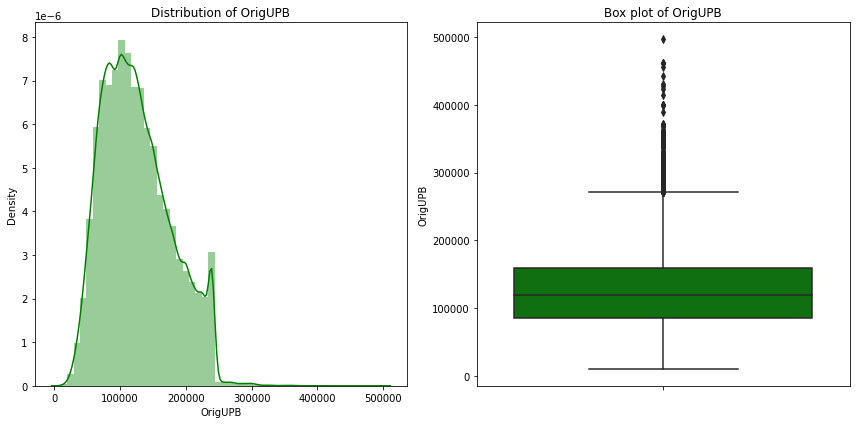

(178196, 28)


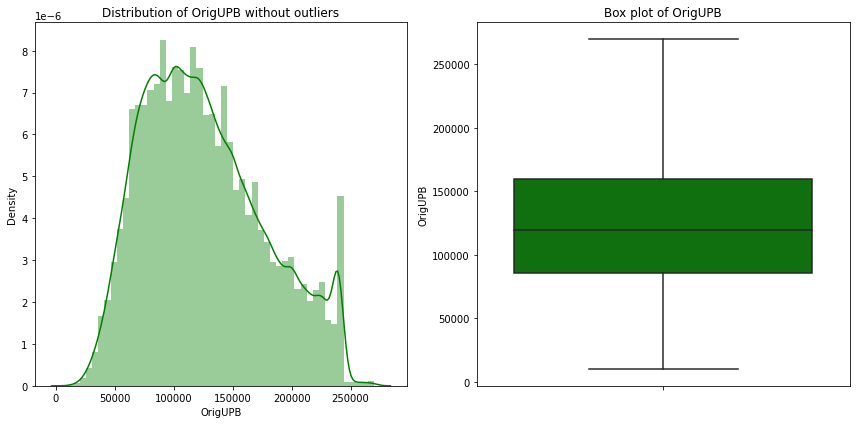

(177725, 28)




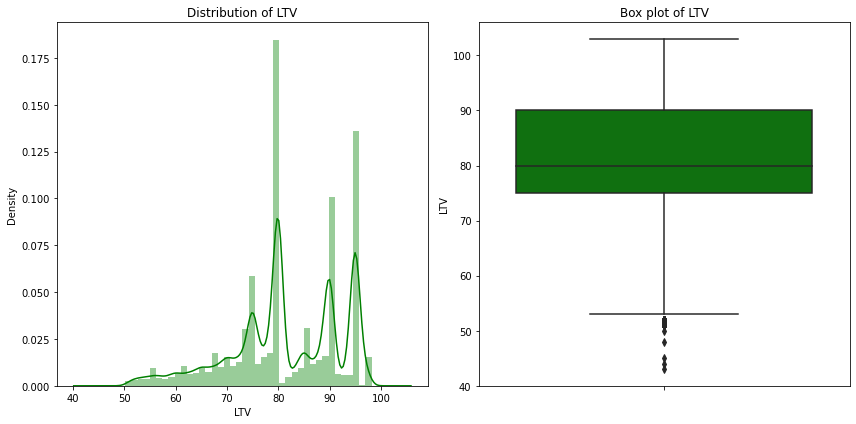

(177725, 28)


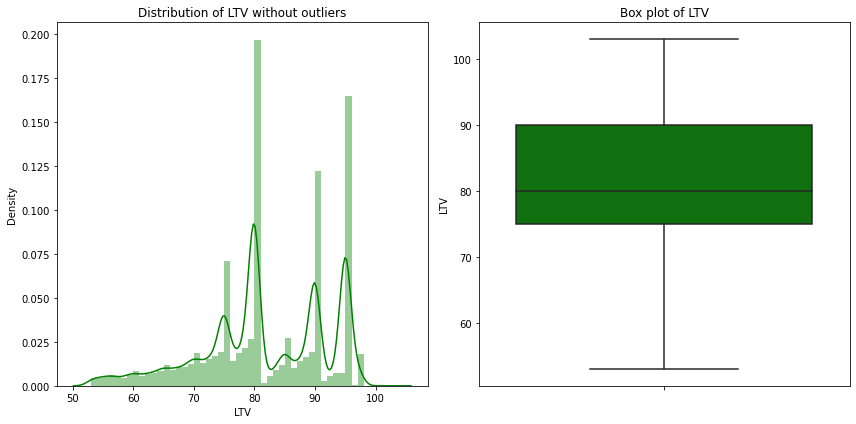

(176499, 28)




In [15]:
for i in ['CreditScore','MIP','OCLTV','DTI','OrigUPB','LTV']:
  check_outliers0(i)
  if i != 'MIP':
    remove_outliers0(i)
  print('')
  print("")

In [16]:
df0['FirstPaymentDate'] = pd.to_datetime(df0['FirstPaymentDate'], format='%d%y%m')
df0['MaturityDate'] = pd.to_datetime(df0['MaturityDate'], format='%d%y%m')

In [17]:
df0.replace({'FirstTimeHomebuyer': {'X':'N'}}, inplace=True)
df0.replace({'PPM': {'X':'N'}}, inplace=True)

In [18]:
mode_of_SellerName0 = df0.pivot_table(values='SellerName', columns='ServicerName', aggfunc=(lambda x: x.mode()[0]))
miss_values0 = df0['SellerName'].isnull()
df0.loc[miss_values0, 'SellerName'] = df0.loc[miss_values0,'ServicerName'].apply(lambda x: mode_of_SellerName0[x])

In [19]:
df0 = df0.drop(['ProductType'], axis=1)
df0 = df0.drop(['LoanSeqNum'], axis=1)
df0 = df0.drop(['LTV'], axis=1)
df0 = df0.drop(['PostalCode'], axis=1)

# Model Building

# Binary Encoding

In [20]:
categorical_columns = ['FirstTimeHomebuyer','MSA','Occupancy','Channel','PPM','PropertyState','PropertyType','LoanPurpose','NumBorrowers','SellerName','ServicerName']

In [21]:
encoder = BinaryEncoder(cols =categorical_columns)
newdata = encoder.fit_transform(df0[categorical_columns])
df0 = pd.concat([df0, newdata], axis = 1)
df0 = df0.drop(categorical_columns, axis = 1)
df0.head()

,CreditScore,FirstPaymentDate,MaturityDate,MIP,Units,OCLTV,DTI,OrigUPB,OrigInterestRate,OrigLoanTerm,...,SellerName_0,SellerName_1,SellerName_2,SellerName_3,SellerName_4,ServicerName_0,ServicerName_1,ServicerName_2,ServicerName_3,ServicerName_4
2786,568,1999-03-19,2029-02-20,25,1,90,28,150000,6.125,360,...,0,0,0,0,1,0,0,0,0,1
2787,568,1999-03-19,2029-02-20,0,1,54,37,46000,7.375,360,...,0,0,0,1,0,0,0,0,1,0
2788,568,1999-03-19,2029-02-20,0,1,54,60,45000,6.875,360,...,0,0,0,1,1,0,0,0,1,1
2789,568,1999-03-19,2029-02-20,25,1,89,8,107000,7.125,360,...,0,0,1,0,0,0,0,1,0,0
2790,568,1999-03-19,2029-02-20,25,1,86,59,123000,6.875,360,...,0,0,1,0,1,0,0,1,0,1


In [22]:
X = df0.drop(['FirstPaymentDate','MaturityDate','EverDelinquent'],axis=1)

In [23]:
Y = df0[['EverDelinquent']]

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

In [25]:
print("Training data : ", X_train.shape)
print("Testing data : ", X_test.shape)

Training data :  (141199, 51)
Testing data :  (35300, 51)


# Min Max scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()

In [28]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [29]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# Random Forest Classifier

In [30]:
rf=RandomForestClassifier(max_depth = 10, n_estimators=1000, random_state = 50)
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=50)

In [31]:
rf_accuracy = round(rf.score(X_train,Y_train)*100)
print("Accuaracy for Random Forest: ",rf_accuracy)

Accuaracy for Random Forest:  100


In [32]:
rf_accuracy = 100*rf.score(X_test,Y_test)
rf_accuracy

100.0

# Linear Support Vector Classifier

In [33]:
lsvc = LinearSVC(dual=False)
lsvc

LinearSVC(dual=False)

In [34]:
lsvc.fit(X_train,Y_train)
score = 100*lsvc.score(X_train,Y_train)
score

95.3724884737144

In [35]:
score = 100*lsvc.score(X_test,Y_test)
score

95.15297450424929

# Saving lsvc model to a file using python pickle

In [36]:
import pickle

In [37]:
with open('model_pickle','wb') as file:
    pickle.dump(lsvc,file)

# Loading saved model

In [38]:
with open('model_pickle','rb') as file:
    mp = pickle.load(file)

In [39]:
df1 = pd.read_csv('LoanExportpart1.csv')

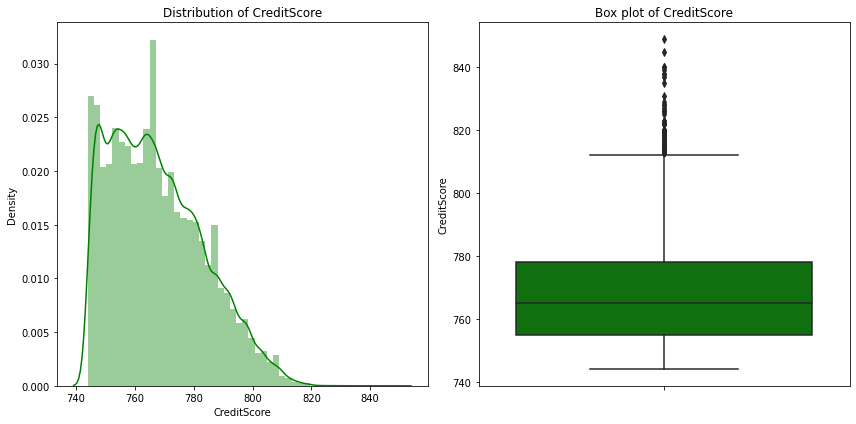

(91451, 28)


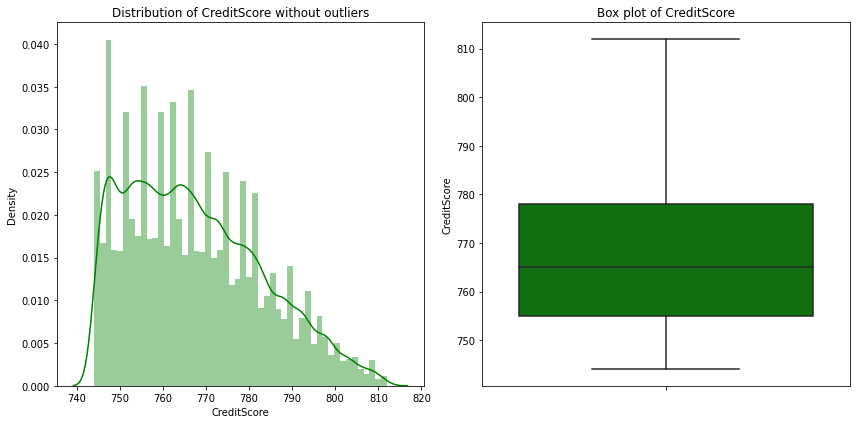

(91184, 28)




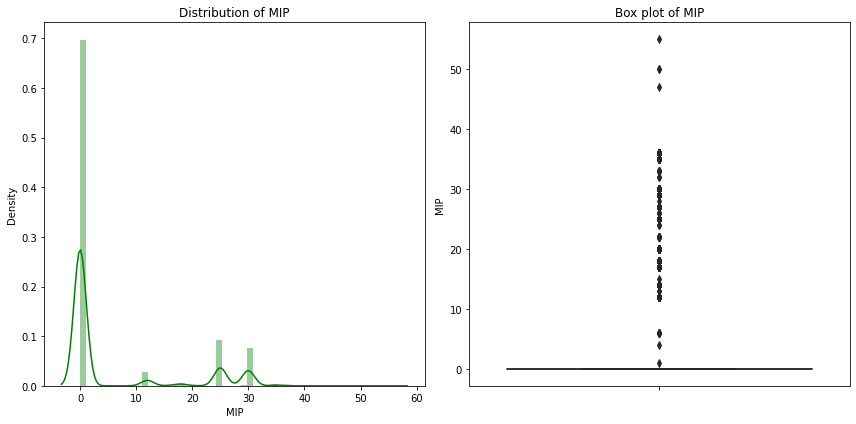

(91184, 28)




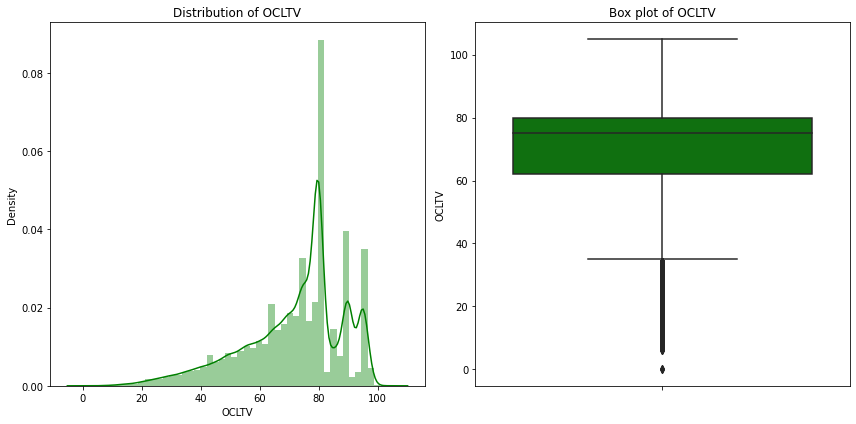

(91184, 28)


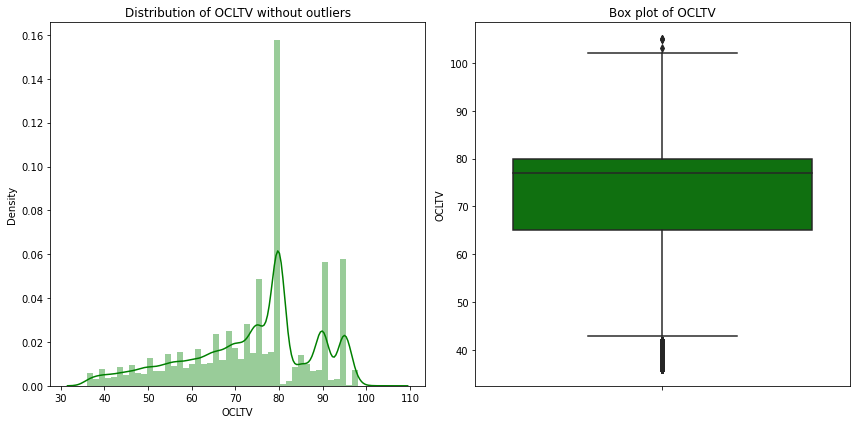

(87454, 28)




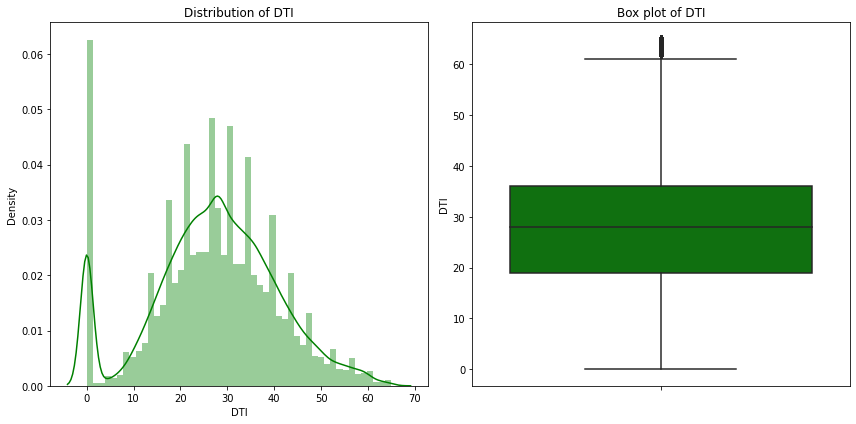

(87454, 28)


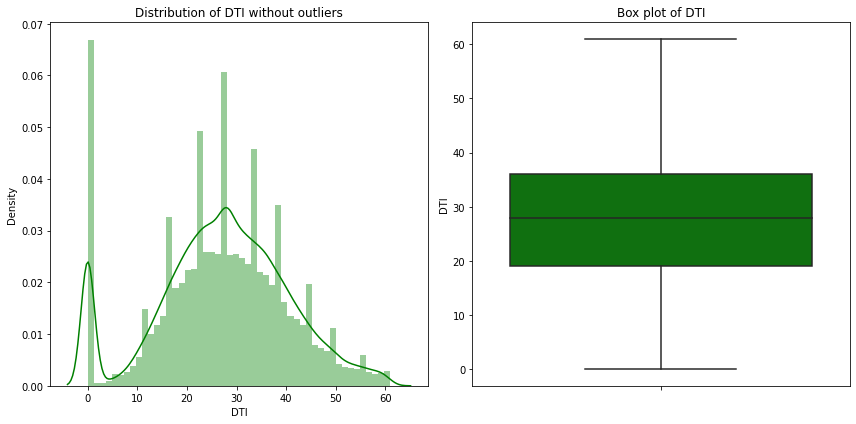

(87198, 28)




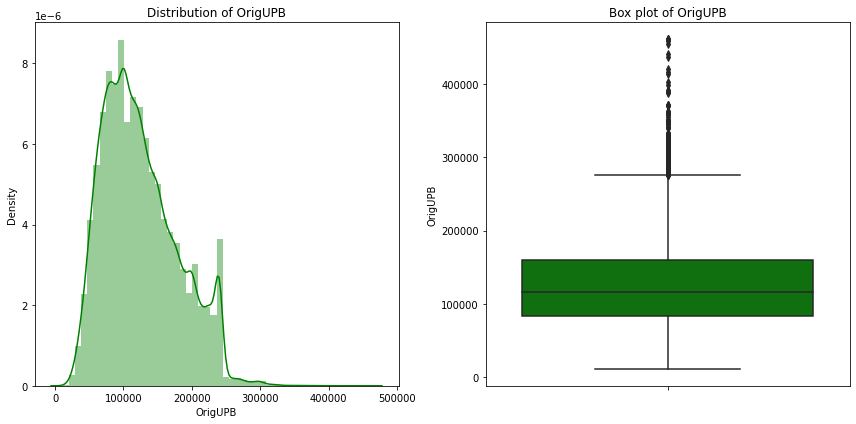

(87198, 28)


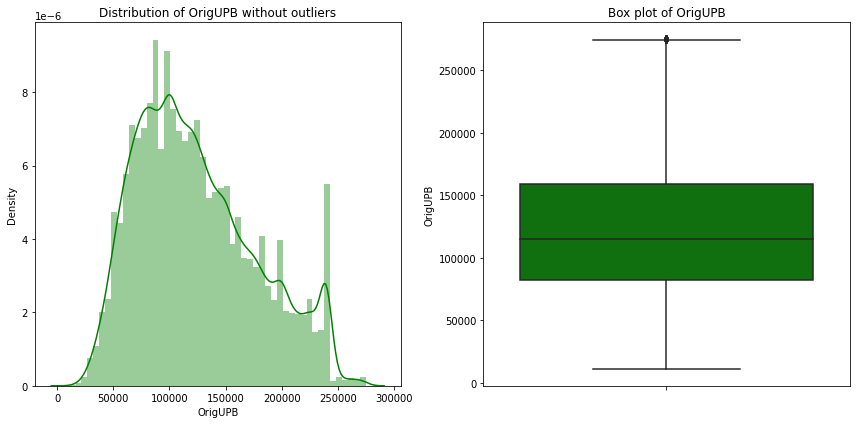

(86816, 28)




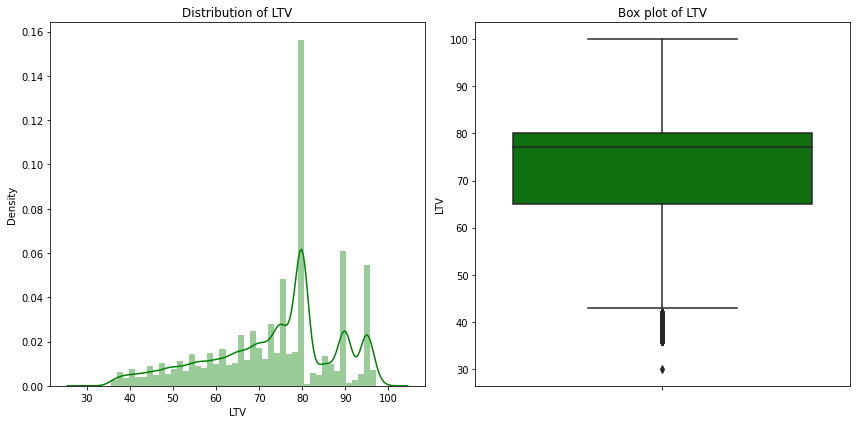

(86816, 28)


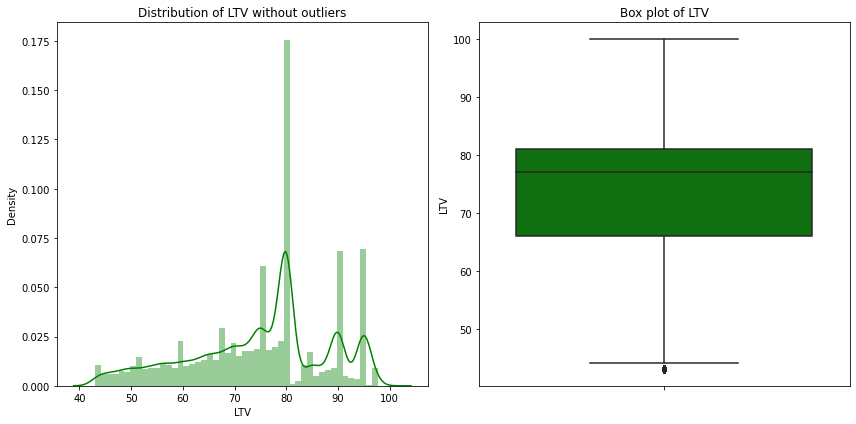

(83941, 28)




In [40]:
def check_outliers1(x):
  global df1
  fig, axes = plt.subplots(1,2,figsize=(12,6))
  sns.distplot(df1[x],color='g',ax=axes[0])
  sns.boxplot(y=df1[x],color='g',ax=axes[1])
  axes[0].set_title('Distribution of ' + x)
  axes[1].set_title('Box plot of '+ x)
  plt.tight_layout()
  plt.show()
  print(df1.shape)
def remove_outliers1(x):
  global df1
  Q1= df1[x].quantile(0.25)
  Q3 = df1[x].quantile(0.75)
  IQR = Q3 - Q1
  upper_limit = Q3 + 1.5 * IQR
  lower_limit = Q1 - 1.5 * IQR
  df1=df1[(df1[x] > lower_limit) & (df1[x] < upper_limit)]
  fig, axes = plt.subplots(1,2,figsize=(12,6))
  sns.distplot(df1[x],color='g',ax=axes[0])
  sns.boxplot(y=df1[x],color='g',ax=axes[1])
  axes[0].set_title('Distribution of '+ x + ' without outliers')
  axes[1].set_title('Box plot of '+ x)
  plt.tight_layout()
  plt.show()
  print(df1.shape)
df1['CreditScore'].replace(to_replace = 0, value = 850, inplace=True)
df1['Units'].replace(to_replace = 0, value = 1, inplace=True)
for i in ['CreditScore','MIP','OCLTV','DTI','OrigUPB','LTV']:
  check_outliers1(i)
  if i != 'MIP':
    remove_outliers1(i)
  print('')
  print("")
df1['FirstPaymentDate'] = pd.to_datetime(df1['FirstPaymentDate'], format='%d%y%m')
df1['MaturityDate'] = pd.to_datetime(df1['MaturityDate'], format='%d%y%m')
df1.replace({'FirstTimeHomebuyer': {'X':'N'}}, inplace=True)
df1.replace({'PPM': {'X':'N'}}, inplace=True)
mode_of_SellerName1 = df1.pivot_table(values='SellerName', columns='ServicerName', aggfunc=(lambda x: x.mode()[0]))
miss_values1 = df1['SellerName'].isnull()
df1.loc[miss_values1, 'SellerName'] = df1.loc[miss_values1,'ServicerName'].apply(lambda x: mode_of_SellerName1[x])
df1 = df1.drop(['ProductType'], axis=1)
df1 = df1.drop(['LoanSeqNum'], axis=1)
df1 = df1.drop(['LTV'], axis=1)
df1 = df1.drop(['PostalCode'], axis=1)
categorical_columns = ['FirstTimeHomebuyer','MSA','Occupancy','Channel','PPM','PropertyState','PropertyType','LoanPurpose','NumBorrowers','SellerName','ServicerName']
encoder = BinaryEncoder(cols =categorical_columns)
newdata = encoder.fit_transform(df1[categorical_columns])
df1 = pd.concat([df1, newdata], axis = 1)
df1 = df1.drop(categorical_columns, axis = 1)
df_data = df1.drop(['FirstPaymentDate','MaturityDate','EverDelinquent'],axis=1)
df_data = scaler.fit_transform(df_data)
df_true = np.array(df1['EverDelinquent'])

In [41]:
df_pred=mp.predict(df_data)

In [42]:
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    accuracy = correct_predictions/len(y_true)
    return accuracy

In [43]:
acc = compute_accuracy(df_true,df_pred)

In [44]:
100 * acc

100.0

In [45]:
with open('rf_pickle','wb') as file:
    pickle.dump(rf,file)

In [46]:
with open('rf_pickle','rb') as file:
    rfp = pickle.load(file)

In [47]:
rf_pred = rfp.predict(df_data)

In [48]:
acc_score = compute_accuracy(df_true,rf_pred)

In [49]:
100*acc_score

100.0